# Bias-Variance trade-off 

Porting the matlab code to Python from https://theclevermachine.wordpress.com/tag/bias-variance-tradeoff/ allows an easy visualization of the bias-variance decomposition.

In [22]:
import numpy as np

# ------------------- function definitions ------------------------ #

# target function
def f(x):
    return np.sin(x+x**2)

# calculate mean squared error
def get_mse(x,y):
    return np.mean((x-y)**2)

# ---------------- set constants ------------------------------ #
N = 25 # OF OBSERVATIONS PER DATASET
K = 1000 # OF DATASETS
noiseSTD = .5 # NOISE STANDARDE DEV.
nTrain = int(np.ceil(N*.9)) # OF TRAINING POINTS
nPolyMax = 12 # MAXIMUM MODEL COMPLEXITY
x_grid = np.linspace(-1,1,N)

# -------------------- prepare containers -----------------------#
mse_train = np.empty([K,nPolyMax])
mse_test = np.empty([K,nPolyMax])
fit_train = np.empty([nTrain,nPolyMax,K])
fit_test = np.empty([N-nTrain,nPolyMax,K])
# save results for train and test errors, bias squared and variance
keys = ['error_train','error_test','bias_squared','variance']
results = {key: {} for key in keys}

# -------------------- fit ---------------------- #
x = x_grid.copy()
# permute input to assign randomly to train and test sets 
np.random.shuffle(x)

# repeat K times
for rep in range(K):
    # add normally distributed noise
    y = f(x)+np.random.normal(0,noiseSTD,len(x))
    #training set  
    x_train = x[:nTrain]
    y_train = y[:nTrain]
    # test set
    x_test = x[(nTrain+1):]
    y_test = y[(nTrain+1):]
    
    # fit polynomials with degree 1 to 12 by ordinary least squares
    for degree in np.arange(1,nPolyMax+1):
        coefs = np.polyfit(x_train,y_train,degree)
        fit_train[:,degree-1,rep] = np.polyval(coefs,x_train)
        fit_test[:,degree-1,rep] = np.polyval(coefs,x_test)
        # calculate mean squared error
        mse_train[rep,degree-1] = get_mse(fit_train[:,degree-1,rep],y_train)
        mse_test[rep,degree-1] = get_mse(fit_test[:,degree-1,rep],y_test)

# ------------------------ calculate results ------------------- #        
for degree in np.arange(1,nPolyMax+1):
    results['error_train'][degree] = np.mean(mse_train[:,degree-1])
    results['error_test'][degree] = np.mean(mse_test[:,degree-1])
    results['bias_squared'][degree] = np.mean((np.mean(fit_train[:,degree-1,:],axis=1)-f(x_train))**2)
    results['variance'][degree] = np.mean(np.var(fit_test[:,degree-1,:],axis=1))



### Plot results

The bias squared and variance components make up the reducible error part and the variance of the noise, the irreducible error part. As the plot shows, adding the irreducible error to the reducible predicts the test error almost perfectly. 

Here, in case of an OLS regression, we can use a mean squared error loss function to choose the best model. As the mean squared error profile seems to be flat around its minimum for polynomials of order 2-4, we could choose a model from this range. Alternatively, for example, with a log-likelihood loss function, we could rely on AIC or BIC statistics for model comparisons.

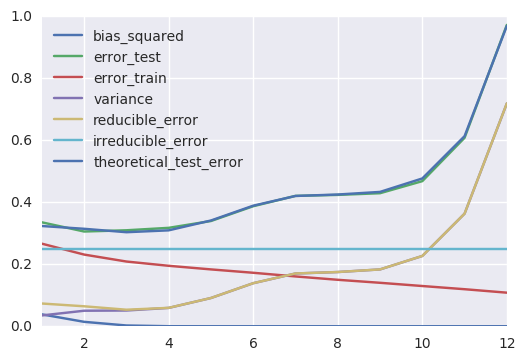

In [38]:
%matplotlib inline
import pandas as pd
import seaborn

result_to_plot = pd.DataFrame.from_dict(results)
result_to_plot['reducible_error'] = result_to_plot['bias_squared']+result_to_plot['variance']
result_to_plot['irreducible_error'] = noiseSTD**2
result_to_plot['theoretical_test_error'] = result_to_plot['irreducible_error']+result_to_plot['reducible_error']

result_to_plot.plot()